In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.typing import types
from tf_agents.policies import random_py_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies import py_policy
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import tf_driver
from tf_agents.drivers import dynamic_episode_driver

import matplotlib.pyplot as plt
import qutip
from qutip import sigmap, expect

import random

import sys
sys.path.append('../')

from environments.qubit_env import QubitEnv, extract_policy
from common.common import EpsilonGreedyPolicy
from temporal_difference.TD_algorithms import double_qlearing_algorithm

%matplotlib inline

2024-03-15 20:06:43.591875: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 20:06:43.786086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 20:06:43.786124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 20:06:43.799631: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-15 20:06:43.828772: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 20:06:43.829485: I tensorflow/core/platform/cpu_feature_guard.cc:1

* System parameters

In [2]:
T = 4
N = 20 # number of time steps

* Define actions and create environment

In [3]:
# define actions
# actions will be the change in the magnetic field
max_Ω = 1
zero_action = np.array(0, dtype = np.float32) # action 0
plus_half_action = np.array(0.5 * max_Ω, dtype = np.float32) # action 1
minus_half_action = np.array(-0.5 * max_Ω, dtype = np.float32) # action 2
plus_action = np.array(1 * max_Ω, dtype = np.float32) # action 1
minus_action = np.array(-1 * max_Ω, dtype = np.float32) # action 2
plus2_action = np.array(2 * max_Ω, dtype = np.float32) # action 3
minus2_action = np.array(-2 * max_Ω, dtype = np.float32) # action 4

nb_actions = 7
# actions = [plus2_action, minus2_action]
# omegas = [-max_Ω, 0, max_Ω]
actions = [zero_action, plus_action, plus_half_action, minus_half_action, minus_action, plus2_action, minus2_action]

# shuffle them randomly to avoid bias
random.shuffle(actions)

omegas = [-max_Ω, -max_Ω / 2, 0, max_Ω / 2, max_Ω]

environment = QubitEnv(T, N, max_Ω, actions, fidelity_threshold = 0.99, verbose_fg = False, nb_actions = nb_actions)

In [4]:
learning_rate = 0.9
gamma = 0.99

(Qtable_qlearning_2000, qlearning_rewards_2000) = double_qlearing_algorithm(
    environment = environment,
    omegas = omegas,
    collect_policy = EpsilonGreedyPolicy,
    nb_episodes = 2000, 
    learning_rate = learning_rate,
    discount = gamma, 
    max_steps = N, 
    nb_actions = nb_actions
)

(Qtable_qlearning_5000, qlearning_rewards_5000) = double_qlearing_algorithm(
    environment = environment,
    omegas = omegas,
    collect_policy = EpsilonGreedyPolicy,
    nb_episodes = 5000, 
    learning_rate = learning_rate,
    discount = gamma, 
    max_steps = N, 
    nb_actions = nb_actions
)

(Qtable_qlearning_10000, qlearning_rewards_10000) = double_qlearing_algorithm(
    environment = environment,
    omegas = omegas,
    collect_policy = EpsilonGreedyPolicy,
    nb_episodes = 10000, 
    learning_rate = learning_rate,
    discount = gamma, 
    max_steps = N, 
    nb_actions = nb_actions
)

(Qtable_qlearning_20000, qlearning_rewards_20000) = double_qlearing_algorithm(
    environment = environment,
    omegas = omegas,
    collect_policy = EpsilonGreedyPolicy,
    nb_episodes = 20000, 
    learning_rate = learning_rate,
    discount = gamma,
    max_steps = N, 
    nb_actions = nb_actions
)

In [10]:
def print_results(optimal_omegas, states, num_iterations, fidelities, avg_returns):
    # append another omega so that the last step can be shown in the figure
    optimal_omegas.append(optimal_omegas[-1])

    population2 = expect(sigmap().dag() * sigmap(), states)
    population1 = 1 - population2

    time_span = np.arange(len(optimal_omegas))
    time_span = [t * T / N for t in time_span]
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    fig.set_figheight(8)
    fig.set_figwidth(12)
    fig.suptitle(f'Double Q-learning {num_iterations} episodes')

    ax1.step(time_span, optimal_omegas, where = 'post')
    ax1.set_ylabel(r"$\frac{\Omega}{\Omega_{max}}$", rotation = 0, fontsize = 12)
    ax1.set_ylim((-1.1, 1.1))
    ax1.set_title("(a)", loc = "right", fontsize = 10)
    ax1.set_xlabel(f"t")

    ax2.plot(time_span, fidelities)
    ax2.axhline(y = 0.99, color = 'r', linestyle = '--', label = '0.99')
    ax2.set_ylabel("Fidelity", rotation = 90, fontsize = 12)
    ax2.set_xlabel(f"t")
    ax2.legend(loc = 'lower right')
    ax2.set_title("(b)", loc = "right", fontsize = 10)

    ax4.plot(time_span, population1, label = r"$P_1$")
    ax4.plot(time_span, population2, label = r"$P_2$")
    ax4.set_ylabel("Populations", rotation = 90, fontsize = 12)
    ax4.set_xlabel(f"t")
    ax4.set_title("(d)", loc = "right", fontsize = 10)
    ax4.legend()

    time_span3 = range(len(avg_returns))
    ax3.plot(time_span3, avg_returns)
    ax3.set_ylabel("Return", rotation = 90, fontsize = 12)
    ax3.set_xlabel(f"episodes")
    ax3.set_title("(c)", loc = "right", fontsize = 10)
    plt.show()

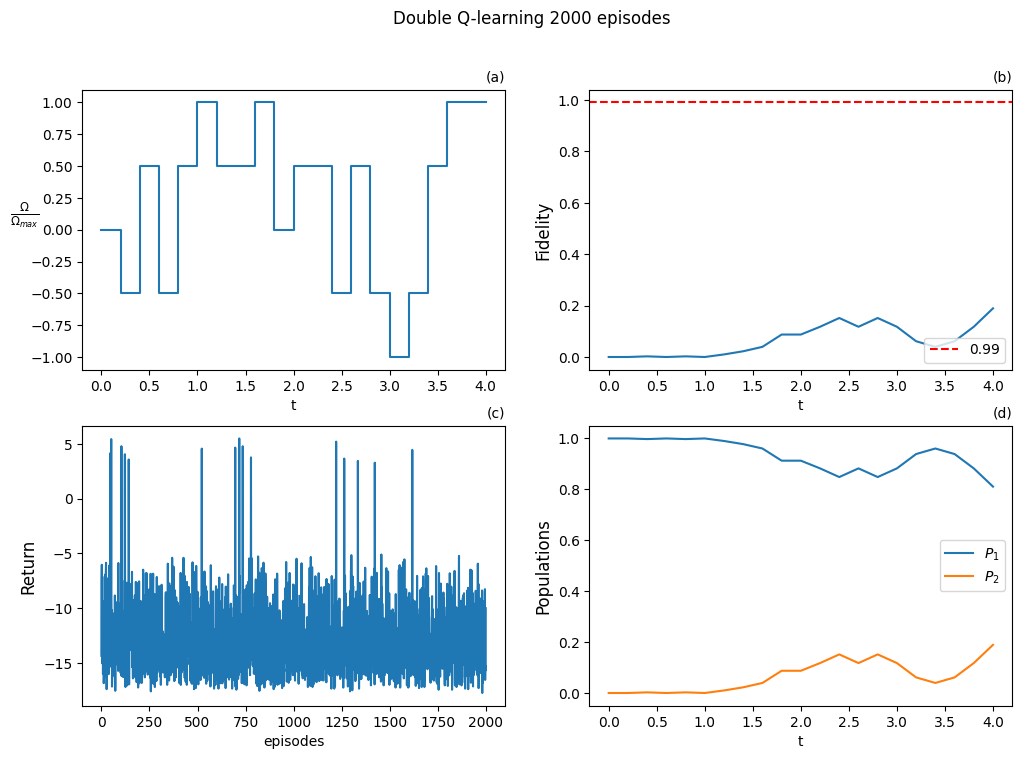

In [11]:
greedy_actions, optimal_omegas, states, fidelities = extract_policy(Qtable_qlearning_2000, environment, actions, omegas, N)

print_results(optimal_omegas, states, 2000, fidelities, qlearning_rewards_2000)

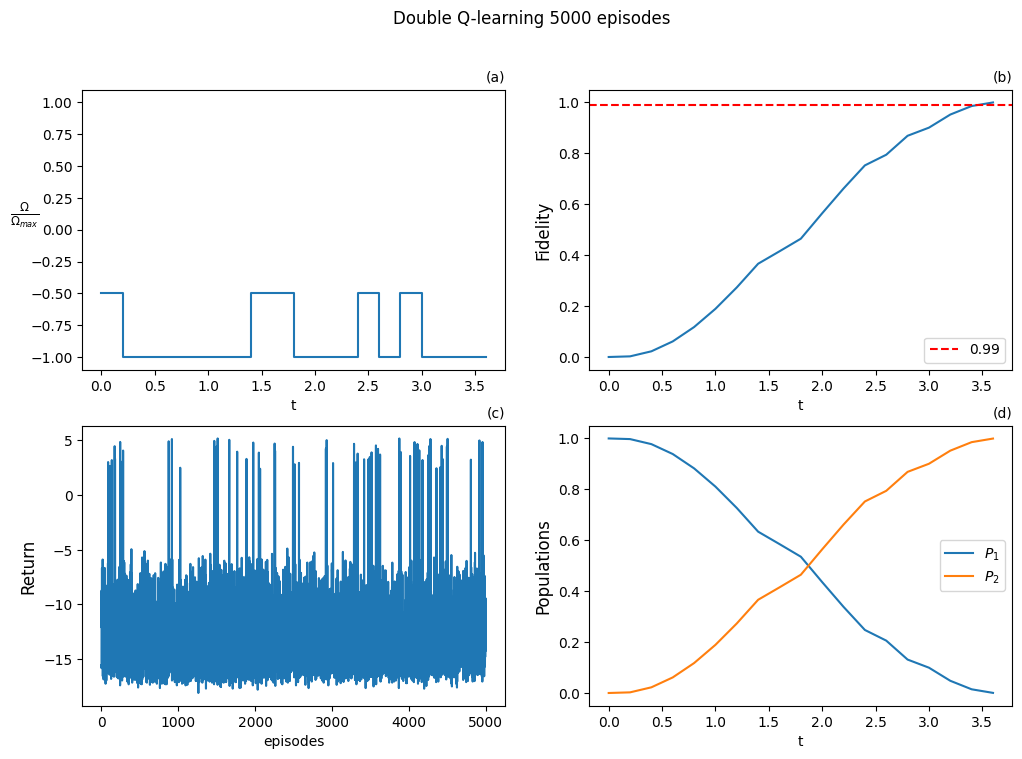

In [12]:
greedy_actions, optimal_omegas, states, fidelities = extract_policy(Qtable_qlearning_5000, environment, actions, omegas, N)

print_results(optimal_omegas, states, 5000, fidelities, qlearning_rewards_5000)

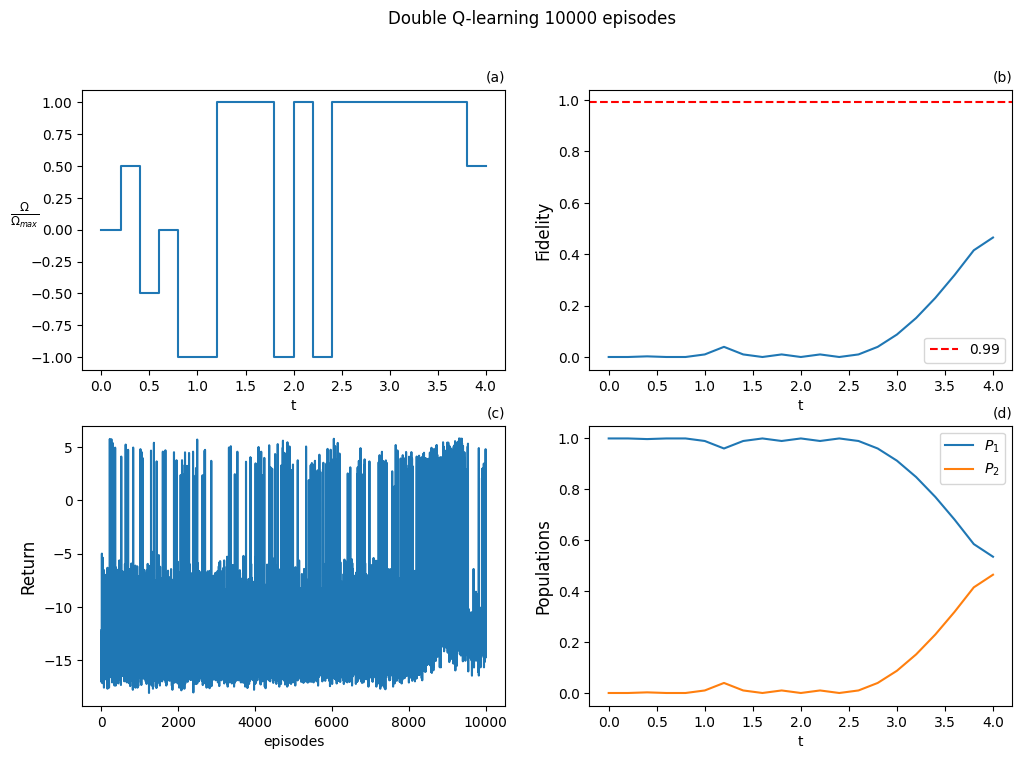

In [13]:
greedy_actions, optimal_omegas, states, fidelities = extract_policy(Qtable_qlearning_10000, environment, actions, omegas, N)

print_results(optimal_omegas, states, 10000, fidelities, qlearning_rewards_10000)

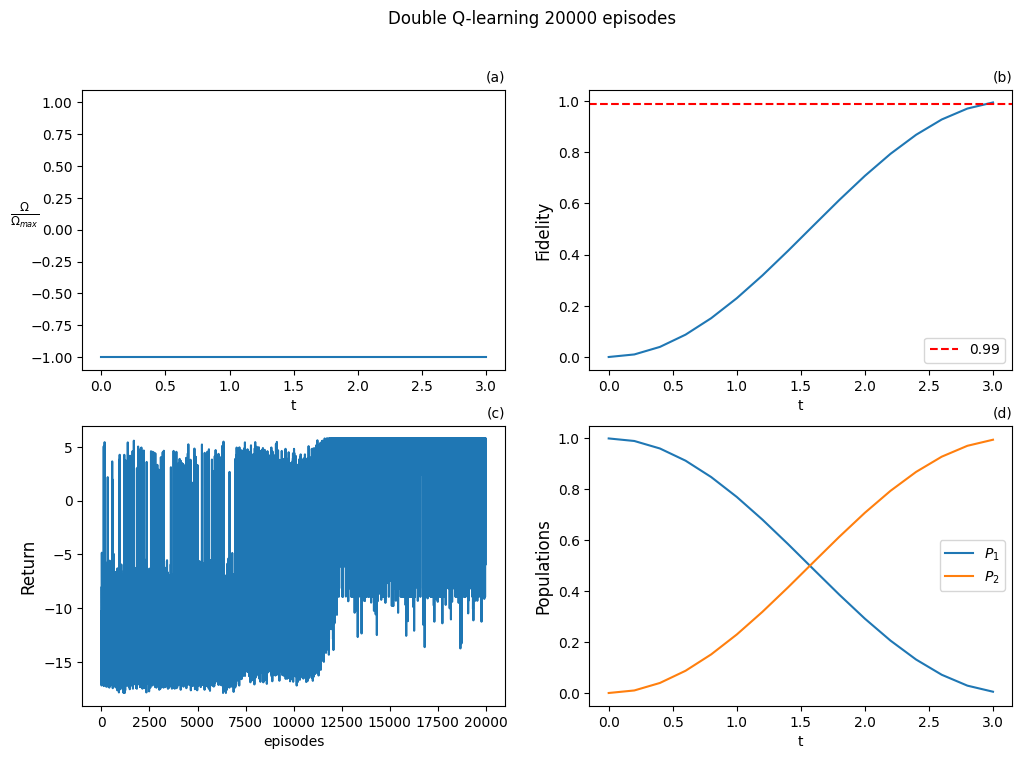

In [14]:
greedy_actions, optimal_omegas, states, fidelities = extract_policy(Qtable_qlearning_20000, environment, actions, omegas, N)

print_results(optimal_omegas, states, 20000, fidelities, qlearning_rewards_20000)